# StackOverflow - Exploratory Data Analysis

Perform an Exploratory Data Analysis over the data included in the BigQuery dataset `bigquery-public-data.stackoverflow`, in order to uncover interesting patterns and potential use cases within the data.

# Setup Notebook

## Imports

In [1]:
# Import Standard Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pandas as pd
import seaborn as sns
from colorama import Style, Fore
from matplotlib.gridspec import GridSpec
from pathlib import Path
from dynaconf import Dynaconf
from scipy.stats import zscore

# Import Package Modules
from src.bigquery_connector.bigquery_connector import BigQueryConnector
from src.types import BigQueryClientConfig

## Setup Plot Characteristics

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

## Define Configurations

In [4]:
# Setup root path
root_path = Path(os.getcwd()).parents[2]

In [5]:
# Read configuration
config = Dynaconf(
    settings_files=[
        root_path / 'configuration' / 'settings.toml'
    ],
    environments=True, 
    env='eda'
)

In [6]:
# Retrieve configurations
read_local = config['read_local']
bigquery_client_config = config['bigquery_client']
relevant_users_config = config['relevant_users']
badges_relevant_users_config = config['badges_relevant_users']

# Read Data

In [8]:
# Switch between reading from local .CSV files or from BigQuery tables
if read_local:
    # Read from local .CSV files
    relevant_users = pd.read_csv(root_path / relevant_users_config['local_path']).iloc[:, 2:] # Skip IDs columns
    badges_relevant_users = pd.read_csv(root_path / badges_relevant_users_config['local_path'])
else:
    # Instance BigQuery Connector
    bigquery_connector = BigQueryConnector(BigQueryClientConfig(**bigquery_client_config))
    
    # Read data from BigQuery
    relevant_users = bigquery_connector.read_from_query_config(relevant_users_config)
    badges_relevant_users = bigquery_connector.read_from_query_config(badges_relevant_users_config)

# Exploratory Data Analysis

## Relevant Users

### General

In [8]:
relevant_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33517 entries, 0 to 33516
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   display_name       33514 non-null  object 
 1   about_me           16121 non-null  object 
 2   age                0 non-null      float64
 3   creation_date      33517 non-null  object 
 4   last_access_date   33517 non-null  object 
 5   location           33506 non-null  object 
 6   reputation         33517 non-null  int64  
 7   up_votes           33517 non-null  int64  
 8   down_votes         33517 non-null  int64  
 9   views              33517 non-null  int64  
 10  profile_image_url  25984 non-null  object 
 11  website_url        10809 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 3.1+ MB


In [9]:
relevant_users.sample(5)

,display_name,about_me,age,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,profile_image_url,website_url
12673,Mustafa Ozhan,NaN,NaN,2017-07-19 20:15:07.840000+00:00,2022-09-24 22:46:50.537000+00:00,"Prague, Czechia",271,11,1,18,https://lh4.googleusercontent.com/-PrHZZ80tMzM...,NaN
606,Nikolay Suvandzhiev,<p>I'm an iOS developer with a passion for goo...,NaN,2012-09-17 18:57:20.920000+00:00,2022-09-25 01:35:23.470000+00:00,"London, UK",8007,385,92,296,https://i.stack.imgur.com/LritX.jpg,https://nikolaysuvandzhiev.com/
22222,Ali Raza,"<p>Hi, I am a Full Stack Engineer at <a href=""...",NaN,2017-04-22 17:08:14.197000+00:00,2022-09-25 04:37:26.947000+00:00,"Abbottabad, Khyber Pakhtunkhwa, Pakistan",135,53,0,29,https://lh4.googleusercontent.com/-CcnnHQI9iUc...,NaN
9909,Pete,"<p>I love building things, and the intellectua...",NaN,2022-05-21 18:30:34.893000+00:00,2022-09-25 04:02:59.673000+00:00,"Lakewood, CO",23,3,0,3,https://lh3.googleusercontent.com/a/AATXAJxGXt...,https://petefowler.dev
24761,jha,NaN,NaN,2018-04-24 19:48:40.300000+00:00,2022-09-25 03:32:29.967000+00:00,"London, UK",138,735,0,1,https://www.gravatar.com/avatar/e2fd2bc7f61e2c...,NaN


In [10]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- All Data -> {red}{relevant_users.shape}\n')

Data Shapes:
- All Data -> (33517, 12)



In [11]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- All Data -> {red}{relevant_users.isnull().any().sum()}\n')

Data Columns with Null Values:
- All Data -> 6



### Null Values

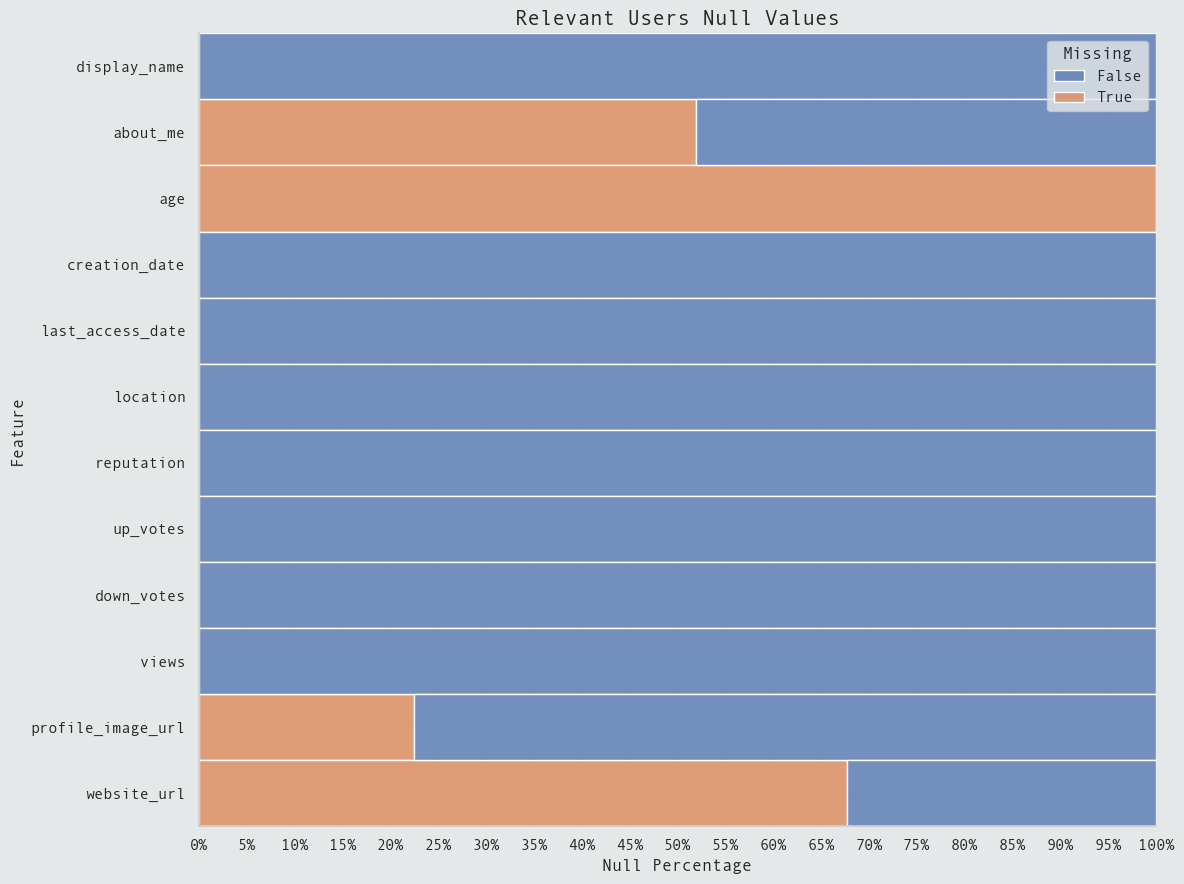

In [12]:
# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(1, 1)

# Plot data
ax = figure.add_subplot(grid_spec[0, 0])

sns.histplot(data=relevant_users.isna().melt(var_name='Feature', value_name='Missing'), 
             y='Feature', 
             hue='Missing', 
             multiple='fill',
             ax=ax)

# Refactor x label as missing percentage
ax.xaxis.set_major_locator(ticker.LinearLocator(21))
ax.xaxis.set_major_formatter('{:.0%}'.format)

# Set title and label
ax.set_title('Relevant Users Null Values', fontsize=15)
ax.set_xlabel('Null Percentage')

plt.show()

- The `age` column is full of null &rarr; Drop it
- The `about_me` is only filled for 50% of the users &rarr; Not possible to use it as a feature

### Numerical Feature Distribution

In [13]:
# Define raw numerical features
raw_numerical_features = [
    'reputation',
    'up_votes',
    'down_votes',
    'views'
]

In [14]:
# Retrieve statistical information
relevant_users[raw_numerical_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
reputation,33517.0,3910.719277,24758.850421,1.0,11.0,128.0,1097.0,1156679.0
up_votes,33517.0,331.055643,1266.953669,0.0,0.0,18.0,166.0,66690.0
down_votes,33517.0,122.266104,1938.247387,0.0,0.0,0.0,5.0,153599.0
views,33517.0,506.298326,5186.963029,0.0,3.0,21.0,129.0,476220.0


- Numerical features have a very high Standard Deviation and different scales &rarr; Require Standardisation

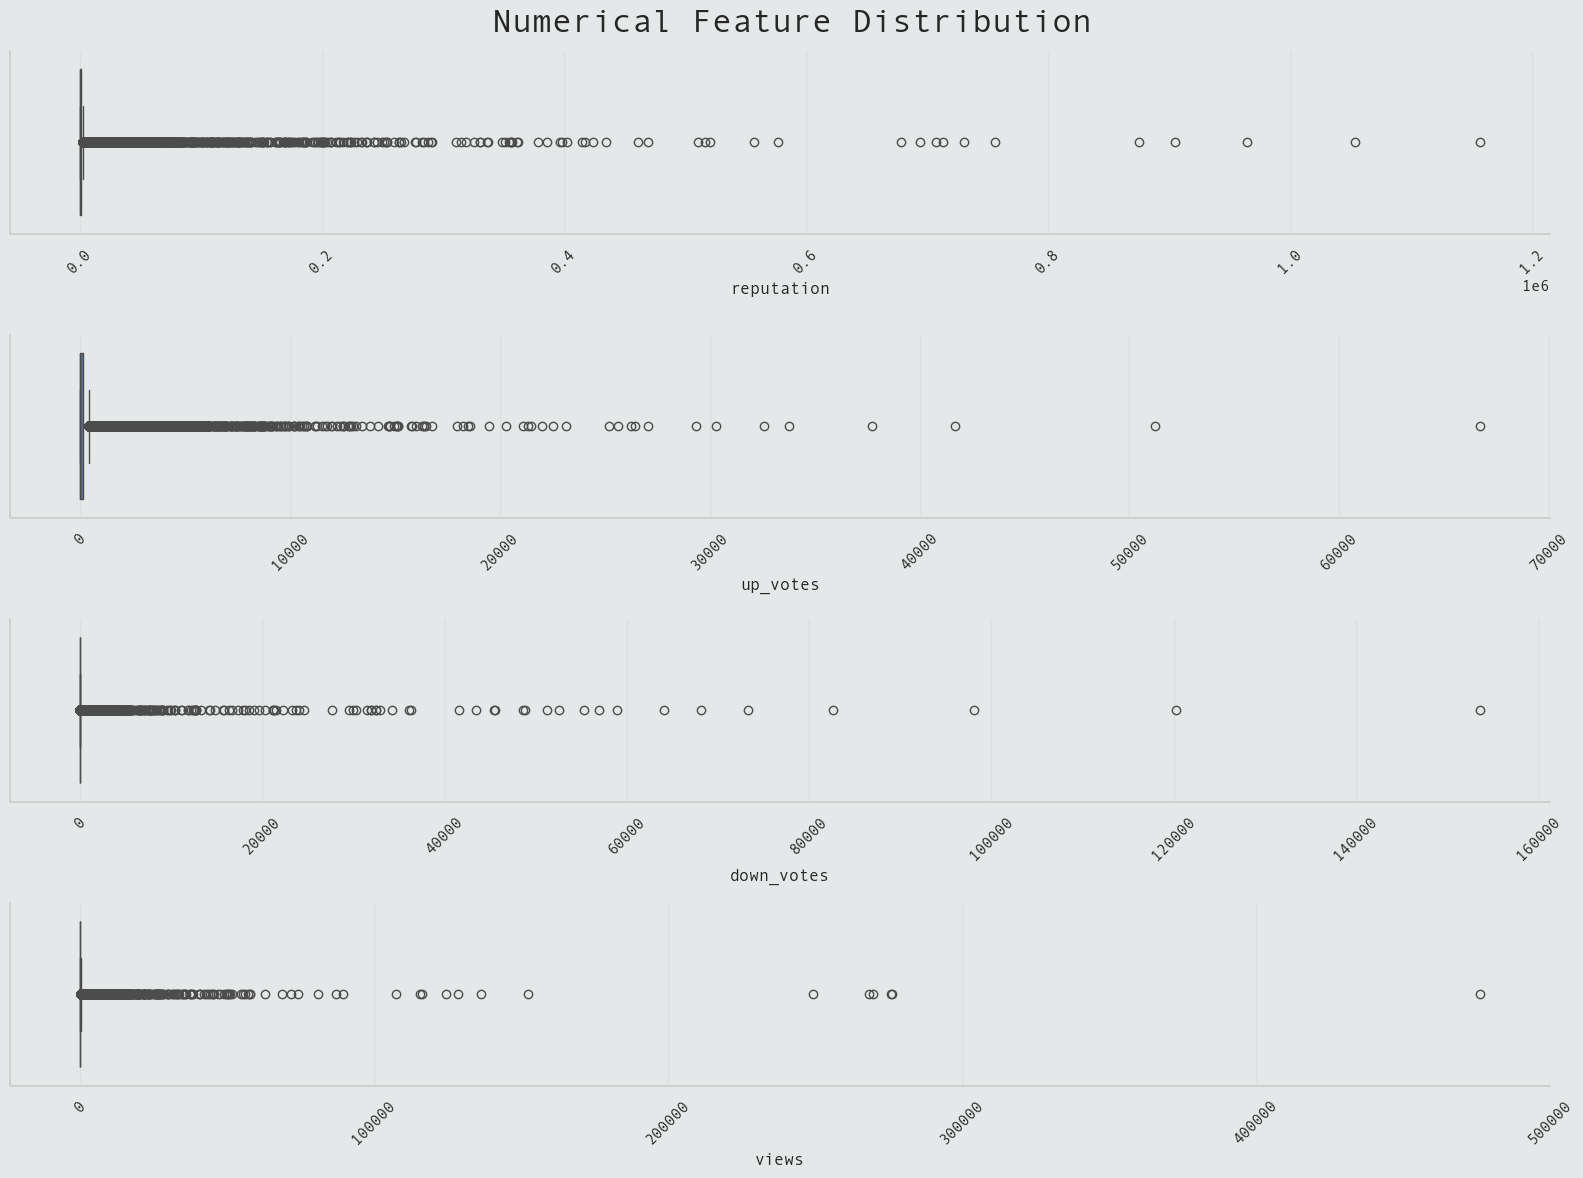

In [15]:
# Define figure and axis
figure, ax = plt.subplots(4, 1, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.boxplot(data=relevant_users,
                x=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- There are quite few outliers, let's count how many hof them through the z-score

In [16]:
# Compute the z-score
z_scores = relevant_users[raw_numerical_features].apply(zscore)

# Identify outliers (greater than 2 Standard Deviations
outliers_count = (z_scores.abs() > 2).sum()

# Display the result as a DataFrame
outliers_df = pd.DataFrame({
    'name': outliers_count.index,
    'outlier_count': outliers_count.values
})

print(outliers_df)

         name  outlier_count
0  reputation            453
1    up_votes            769
2  down_votes            172
3       views            247


- Since they are not too many, we can safely drop them

### Categorical Feature Distribution

In [17]:
# Define raw categorical features
raw_categorical_features = 'location'

In [18]:
# Count number of unique values
relevant_users[raw_categorical_features].describe().transpose()

count     33506
unique     8231
top       India
freq        718
Name: location, dtype: object

In [20]:
# Show the top ten location per number of records
relevant_users.groupby(raw_categorical_features).size().sort_values(ascending=False).rename('Count')

location
India                                     718
Dhaka, Bangladesh                         419
United States                             381
Germany                                   366
Brazil                                    290
                                         ... 
Ужгород, Закарпатська область, Україна      1
日本東京都八王子市東浅川町５４９−３ ＳＩＤＯＣＯ．，ＬＴＤ．             1
東京                                          1
美国加利福尼亚州核桃市邮政编码: 91789                      1
대한민국                                        1
Name: Count, Length: 8231, dtype: int64

- As expected, the column is full of poor quality data. There is both `USA` and `United States`, or both `India` and `Bangalore, Karnataka, India` &rarr; For now it's better to not use it

### Datetime Feature Distribution

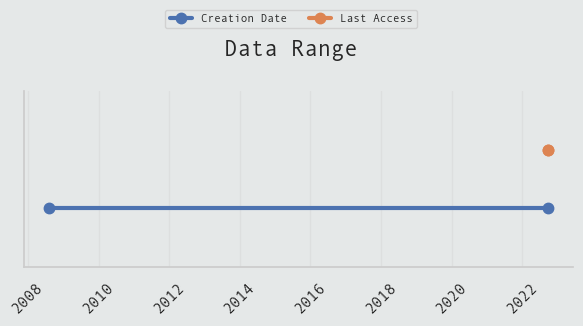

In [29]:
# Convert dates to DateTime
relevant_users['creation_date'] = pd.to_datetime(relevant_users['creation_date'], errors='coerce')
relevant_users['last_access_date'] = pd.to_datetime(relevant_users['last_access_date'], errors='coerce')

# Compute the min and max time range the `creation_date` and `last_access_date`
creation_date_range = relevant_users['creation_date'].agg(['min', 'max'])
last_access_date_range = relevant_users['last_access_date'].agg(['min', 'max'])

# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 3))

# Plot the train time range
ax.plot(creation_date_range, 
        [0.2, 0.2], 
        linewidth=3, 
        marker='.', 
        markersize=15, 
        label='Creation Date')

# Plot the test time rage
ax.plot(last_access_date_range, 
        [0.3, 0.3], 
        linewidth=3, 
        marker='.', 
        markersize=15, 
        label='Last Access')

# Refine plot height
ax.set_ylim(0.1, 0.4)

# Remove the y-ticks since it's not need
ax.set_yticks(ticks=[]);

# Set subplot tick rotation
ax.tick_params(labelrotation=45)
    
# Retrieve legend information
handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
ax.legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.10), 
              fontsize=8,
              ncol=len(handles))

# Set figure Title
figure.suptitle('Data Range',
                fontweight='bold',
                fontsize=16)

plt.tight_layout()


- There is huge interval of `creation_date` &rarr; Not use it for now

## Badges

### General

In [9]:
badges_relevant_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44865 entries, 0 to 44864
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 44865 non-null  int64 
 1   user_name               44859 non-null  object
 2   user_about_me           27611 non-null  object
 3   user_creation_date      44865 non-null  object
 4   user_last_access_date   44865 non-null  object
 5   user_location           44855 non-null  object
 6   user_reputation         44865 non-null  int64 
 7   user_up_votes           44865 non-null  int64 
 8   user_down_votes         44865 non-null  int64 
 9   user_views              44865 non-null  int64 
 10  user_profile_image_url  33912 non-null  object
 11  user_website_url        17503 non-null  object
 12  badge_name              44864 non-null  object
 13  badge_date              44865 non-null  object
 14  badge_class             44865 non-null  int64 
 15  ba

In [10]:
badges_relevant_users.sample(5)

,user_id,user_name,user_about_me,user_creation_date,user_last_access_date,user_location,user_reputation,user_up_votes,user_down_votes,user_views,user_profile_image_url,user_website_url,badge_name,badge_date,badge_class,badge_tag_based,badge_rank
12708,1695960,Robert Crovella,<p>Employee of NVIDIA Corporation. The views a...,2012-09-25 01:26:56.493000+00:00,2022-09-25 01:58:36.713000+00:00,Dallas TX,134910,2443,7745,16239,NaN,NaN,Yearling,2022-09-25 01:31:06.550000+00:00,2,False,1
292,9871463,Dinko Pehar,<p>Skilled software developer with many years ...,2018-05-30 16:11:45.740000+00:00,2022-09-25 05:38:52.697000+00:00,"Mostar, Bosnia and Herzegovina",4681,2092,38,519,https://i.stack.imgur.com/3KP5T.jpg?s=128&g=1,https://pehar.dev/about,Yearling,2022-05-30 16:27:48.797000+00:00,2,False,1
27812,2486214,Adrian,NaN,2013-06-14 13:17:32.323000+00:00,2022-09-25 05:20:13.493000+00:00,Australia,1032,18,0,39,NaN,NaN,Famous Question,2022-08-29 20:51:52.197000+00:00,1,False,1
15250,18642316,ajai.s,<p>Interested in Learning and Developing Web A...,2022-03-31 10:28:04.137000+00:00,2022-09-25 05:08:22.693000+00:00,"Chennai, India.",310,15,1,22,https://lh3.googleusercontent.com/a/AATXAJwApb...,NaN,Enthusiast,2022-05-24 02:42:07.340000+00:00,2,False,1
25457,1525938,Michael Sawczyn,NaN,2012-07-14 18:06:06.237000+00:00,2022-09-25 02:52:58.777000+00:00,Ohio,205,2,0,38,NaN,NaN,Popular Question,2022-06-03 14:48:47.453000+00:00,3,False,2


In [11]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- All Data -> {red}{badges_relevant_users.shape}\n')

Data Shapes:
- All Data -> (44865, 17)



In [12]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- All Data -> {red}{relevant_users.isnull().any().sum()}\n')

Data Columns with Null Values:
- All Data -> 5



### Null Values

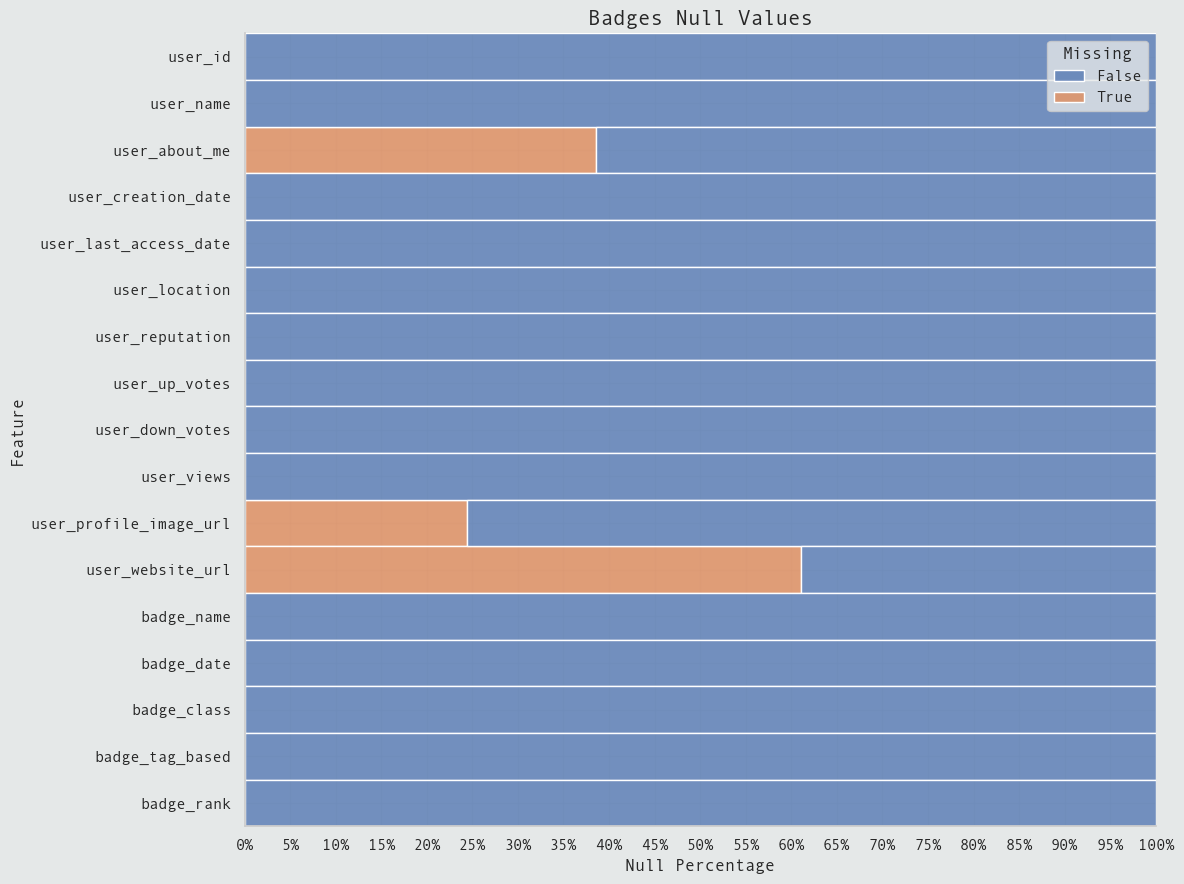

In [15]:
# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(1, 1)

# Plot data
ax = figure.add_subplot(grid_spec[0, 0])

sns.histplot(data=badges_relevant_users.isna().melt(var_name='Feature', value_name='Missing'), 
             y='Feature', 
             hue='Missing', 
             multiple='fill',
             ax=ax)

# Refactor x label as missing percentage
ax.xaxis.set_major_locator(ticker.LinearLocator(21))
ax.xaxis.set_major_formatter('{:.0%}'.format)

# Set title and label
ax.set_title('Badges Null Values', fontsize=15)
ax.set_xlabel('Null Percentage')

plt.show()

- The null columns from the `relevant_users` table have been already addressed &rarr; Nothing do to

### Categorical Feature Distribution

In [16]:
# Define raw categorical features
raw_categorical_features = 'badge_name'

In [17]:
# Count number of unique values
badges_relevant_users[raw_categorical_features].describe().transpose()

count                45545
unique                 348
top       Popular Question
freq                  6925
Name: badge_name, dtype: object

In [18]:
# Show the top ten badge names per number of records
badges_relevant_users.groupby(raw_categorical_features).size().sort_values(ascending=False).rename('Count')

badge_name
Popular Question    6925
Yearling            6535
Notable Question    3471
Nice Answer         2681
Necromancer         1916
                    ... 
swiftui                1
swing                  1
symfony                1
templates              1
xml                    1
Name: Count, Length: 348, dtype: int64

- The feature is well curated &rarr; Use it through an encoding/embedding

# Conclusions



- Drop the `age` , `about_me`, `location` and `creation_date` columns
- Drop outliers with the z-score from the columns: `reputation`, `up_votes`, `down_votes` and `views`